In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import SolveLinSys
from utilities import compute_derivatives

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} - \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [2]:
def false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (z_mat, b_mat) = np.meshgrid(z_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])

    if v0 is None:
#         v0 = δ*η*b_mat
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        e = b_mat*δ*η / (b_mat*τ*z_mat + ℓ)
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)

        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        D = b_mat*(δ*η*np.log(e) - τ*z_mat*e + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

#         print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [3]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

In [4]:
# Grid setting
n_z = 20
z_min = 1e-6
z_max = 2
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 100
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

In [5]:
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [6]:
ψs = []
es = []
ψs_next = []
es_next = []

# ψ_guess, _ = false_transient(z_grid, b_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2000)

for i, ℓ in enumerate(np.exp(log_ell_grid)):
    print(i)
    max_iter = 1000
    ψ, e = false_transient(z_grid, b_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψ_next, e_next = false_transient(z_grid, b_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψs.append(ψ)
    es.append(e)
    ψs_next.append(ψ_next)
    es_next.append(e_next)

0
Iteration 1000: LHS Error: 3.69276168451756e-06; RHS Error 9.800479283823718e-05
Iteration 1000: LHS Error: 3.7193366902578233e-06; RHS Error 9.482559436526478e-05
1
Iteration 1000: LHS Error: 3.717464226575453e-06; RHS Error 9.505023579635592e-05
Iteration 1000: LHS Error: 3.742377088194592e-06; RHS Error 9.205337070912684e-05
2
Iteration 1000: LHS Error: 3.741538827419129e-06; RHS Error 9.215449183635712e-05
Iteration 1000: LHS Error: 3.7648827442529793e-06; RHS Error 8.933106118829694e-05
3
Iteration 1000: LHS Error: 3.7649914379606596e-06; RHS Error 8.931787870629327e-05
Iteration 1000: LHS Error: 3.7868561496043167e-06; RHS Error 8.665932953517259e-05
4
Iteration 1000: LHS Error: 3.787829487207541e-06; RHS Error 8.65406666179405e-05
Iteration 1000: LHS Error: 3.80830049570742e-06; RHS Error 8.40387829778291e-05
5
Iteration 1000: LHS Error: 3.810060939489924e-06; RHS Error 8.382307778201793e-05
Iteration 1000: LHS Error: 3.829219632403742e-06; RHS Error 8.146997136580813e-05
6
It

Iteration 1000: LHS Error: 7.083079787643248e-06; RHS Error 1.854769378626807e-05
Iteration 1000: LHS Error: 7.096515110532192e-06; RHS Error 1.8470528615949114e-05
50
Iteration 1000: LHS Error: 7.170885433900598e-06; RHS Error 1.8055466700807126e-05
Iteration 1000: LHS Error: 7.1837953611285366e-06; RHS Error 1.7985472668247842e-05
51
Iteration 1000: LHS Error: 7.258707746701093e-06; RHS Error 1.7591061719952352e-05
Iteration 1000: LHS Error: 7.271112712418926e-06; RHS Error 1.752765673183128e-05
52
Iteration 1000: LHS Error: 7.346546023159067e-06; RHS Error 1.7153498168643493e-05
Iteration 1000: LHS Error: 7.3584656154826455e-06; RHS Error 1.70961418721994e-05
53
Iteration 1000: LHS Error: 7.434399505810985e-06; RHS Error 1.674180915246142e-05
Iteration 1000: LHS Error: 7.445852585108437e-06; RHS Error 1.6690000413930694e-05
54
Iteration 1000: LHS Error: 7.522267648964881e-06; RHS Error 1.6355042991597385e-05
Iteration 1000: LHS Error: 7.5332723616372554e-06; RHS Error 1.630831742674

Iteration 1000: LHS Error: 1.1396635528376775e-05; RHS Error 1.304111394983392e-05
Iteration 1000: LHS Error: 1.1398521964051112e-05; RHS Error 1.304252492140465e-05
99
Iteration 1000: LHS Error: 1.1484787890245207e-05; RHS Error 1.3108016770393363e-05
Iteration 1000: LHS Error: 1.1486600098031818e-05; RHS Error 1.3109412399500558e-05
100
Iteration 1000: LHS Error: 1.1572942457363511e-05; RHS Error 1.3176806335779089e-05
Iteration 1000: LHS Error: 1.1574683301929234e-05; RHS Error 1.3178182804545588e-05
101
Iteration 1000: LHS Error: 1.166109902049628e-05; RHS Error 1.324734575256602e-05
Iteration 1000: LHS Error: 1.1662771332965338e-05; RHS Error 1.3248699919290277e-05
102
Iteration 1000: LHS Error: 1.1749257456256101e-05; RHS Error 1.3319506641694573e-05
Iteration 1000: LHS Error: 1.1750863924436805e-05; RHS Error 1.3320835858547952e-05
103
Iteration 1000: LHS Error: 1.1837417715584997e-05; RHS Error 1.3393168704855287e-05
Iteration 1000: LHS Error: 1.1838960943866272e-05; RHS Error 

Iteration 1000: LHS Error: 1.5629324129295963e-05; RHS Error 1.709542287415286e-05
Iteration 1000: LHS Error: 1.5629598281940993e-05; RHS Error 1.709569996053372e-05
147
Iteration 1000: LHS Error: 1.5717521002572843e-05; RHS Error 1.718455502521801e-05
Iteration 1000: LHS Error: 1.5717784354135622e-05; RHS Error 1.718482114290243e-05
148
Iteration 1000: LHS Error: 1.5805718177719363e-05; RHS Error 1.7273668994638057e-05
Iteration 1000: LHS Error: 1.5805971153776133e-05; RHS Error 1.7273924571636098e-05
149
Iteration 1000: LHS Error: 1.589391566411691e-05; RHS Error 1.7362762859786992e-05
Iteration 1000: LHS Error: 1.5894158673313008e-05; RHS Error 1.7363008308819944e-05
150
Iteration 1000: LHS Error: 1.5982113450385693e-05; RHS Error 1.7451834953451355e-05
Iteration 1000: LHS Error: 1.598234688537925e-05; RHS Error 1.7452070671720695e-05
151
Iteration 1000: LHS Error: 1.6070311564309048e-05; RHS Error 1.7540883872785426e-05
Iteration 1000: LHS Error: 1.6070535802298336e-05; RHS Error 1

Iteration 1000: LHS Error: 1.9863018545007716e-05; RHS Error 2.1346456586245803e-05
195
Iteration 1000: LHS Error: 1.9951182263222567e-05; RHS Error 2.143449765217107e-05
Iteration 1000: LHS Error: 1.995122050674203e-05; RHS Error 2.1434535839314622e-05
196
Iteration 1000: LHS Error: 2.0039385863535042e-05; RHS Error 2.152256664606357e-05
Iteration 1000: LHS Error: 2.003942259959368e-05; RHS Error 2.1522603324099828e-05
197
Iteration 1000: LHS Error: 2.0127589511975685e-05; RHS Error 2.1610624194592747e-05
Iteration 1000: LHS Error: 2.0127624801025146e-05; RHS Error 2.1610659422680988e-05
198
Iteration 1000: LHS Error: 2.0215793201272536e-05; RHS Error 2.1698670688161592e-05
Iteration 1000: LHS Error: 2.021582709937908e-05; RHS Error 2.1698704523815055e-05
199
Iteration 1000: LHS Error: 2.0303996976833716e-05; RHS Error 2.1786706547019443e-05
Iteration 1000: LHS Error: 2.030402953928645e-05; RHS Error 2.1786739045884804e-05


In [7]:
ϕs = []
rs = []
ψs_new = []
for i in range(len(ψs)):
    ψ_b1_i = ψs[i][:, -1]
    ψ_b1_ip1 = ψs_next[i][:, -1]
    dψ = (ψ_b1_ip1-ψ_b1_i)/ℓ_step
    ψ = (ψ_b1_ip1+ψ_b1_i)/2.
    ℓ = np.exp(log_ell_grid)[i] + ℓ_step/2.
    r = -dψ
    ϕ = ψ + ℓ*r
    ψs_new.append(ψ)
    ϕs.append(ϕ)
    rs.append(r)

In [24]:
z_loc = 10
ϕ_z = np.array([ϕ[z_loc] for ϕ in ϕs])
r_z = np.array([r[z_loc] for r in rs])
sort_indices = np.argsort(r_z)
ϕ_z_sorted = ϕ_z[sort_indices]
r_z_sorted = r_z[sort_indices]

# Calculate dϕ/dr, e_star and Et
r_z, indices = np.unique(r_z_sorted, return_index=True)
ϕ_z = ϕ_z_sorted[indices]
ϕ_der = (ϕ_z[1:]-ϕ_z[:-1])/(r_z[1:]-r_z[:-1])
r_z = (r_z[1:]+r_z[:-1])/2
ϕ_z = (ϕ_z[1:]+ϕ_z[:-1])/2
e_z = δ*η/(τ*z_grid[z_loc]+ϕ_der)

In [25]:
def simulate_emission(e_grid, r_grid, r_start=1500, T=100):
    """
    Simulate emission trajectory baesd on grids of emission and reserve.

    Parameters
    ----------
    e_grid : (N, ) ndarray
        Grid of emission.
    r_grid : (N, ) ndarray
        Grid of reserve.

    Returns
    -------
    Et : (T, ) ndarray
        Emission trajectory.

    """
    Et = np.zeros(T)
    r_remain = r_start
    for i in range(T):
        loc = find_nearest_value(r_grid, r_remain)
        Et[i] = e_grid[loc]
        r_remain = r_remain - Et[i]
    return Et


def find_nearest_value(array, value):
    loc = np.abs(array - value).argmin()
    return loc

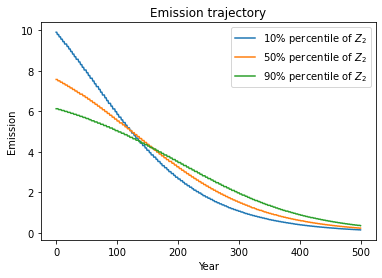

In [33]:
import matplotlib.pyplot as plt
Et_10 = simulate_emission(e_z, r_z, r_start=1500, T=500)
plt.plot(Et_7, label=r'10% percentile of $Z_2$')
plt.plot(Et_10, label=r'50% percentile of $Z_2$')
plt.plot(Et_13, label=r'90% percentile of $Z_2$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Emission')
plt.title('Emission trajectory')
plt.savefig('plot.pdf')